In [16]:
import pandas as pd
import numpy as np
from scipy import stats

from openpyxl import load_workbook

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid")
%matplotlib inline


In [3]:
df = pd.read_csv("../data_prepared.csv")
df.head()

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada
0,5,20,23,1.603110,1,2.5,0.20,0.05,32.57,2.202321
1,6,14,49,-0.650644,1,2.4,0.05,0.13,45.12,-1.258732
2,7,20,49,0.437375,1,2.9,0.12,0.18,69.79,-0.460027
3,6,13,31,-0.161035,0,3.7,0.10,0.10,47.70,-0.699639
4,5,15,48,-0.242637,1,2.1,0.17,0.12,42.69,-0.326910


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   qtd_membros             5000 non-null   int64  
 1   duracao_dias            5000 non-null   int64  
 2   cartoes_previstos       5000 non-null   int64  
 3   story_points_previstos  5000 non-null   float64
 4   tipo_dominio            5000 non-null   int64  
 5   complexidade_media      5000 non-null   float64
 6   percentual_bugs         5000 non-null   float64
 7   percentual_retrabalho   5000 non-null   float64
 8   velocidade_passada      5000 non-null   float64
 9   produtividade_estimada  5000 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 390.8 KB


#### Testando novas features

In [40]:

### craindo novas features

# 1. Bugs e retrabalho estimados
df["qtd_bugs"] = df["percentual_bugs"] * df["cartoes_previstos"]

df["qtd_retrabalho"] = df["percentual_retrabalho"] * df["cartoes_previstos"]

# 2. Carga por membro
df["carga_cartoes_por_membro"] = df["cartoes_previstos"] / df["qtd_membros"]
df["carga_storypoints_por_membro"] = df["story_points_previstos"] / df["qtd_membros"]

# 3. Eficiência (velocidade normalizada)
df["eficiencia"] = df["velocidade_passada"] / df["cartoes_previstos"]

# 4. Complexidade total
df["complexidade_total"] = df["complexidade_media"] * df["cartoes_previstos"]

# 5. Produtividade gap
df["produtividade_gap"] = (df["velocidade_passada"] / df["qtd_membros"]) - df["produtividade_estimada"]




In [41]:
df.head()

,qtd_membros,duracao_dias,cartoes_previstos,story_points_previstos,tipo_dominio,complexidade_media,percentual_bugs,percentual_retrabalho,velocidade_passada,produtividade_estimada,qtd_bugs,qtd_retrabalho,carga_cartoes_por_membro,carga_storypoints_por_membro,eficiencia,complexidade_total,produtividade_gap
0,5,20,23,1.603110,1,2.5,0.20,0.05,32.57,2.202321,4.60,1.15,4.600000,0.320622,1.416087,57.5,4.311679
1,6,14,49,-0.650644,1,2.4,0.05,0.13,45.12,-1.258732,2.45,6.37,8.166667,-0.108441,0.920816,117.6,8.778732
2,7,20,49,0.437375,1,2.9,0.12,0.18,69.79,-0.460027,5.88,8.82,7.000000,0.062482,1.424286,142.1,10.430027
3,6,13,31,-0.161035,0,3.7,0.10,0.10,47.70,-0.699639,3.10,3.10,5.166667,-0.026839,1.538710,114.7,8.649639
4,5,15,48,-0.242637,1,2.1,0.17,0.12,42.69,-0.326910,8.16,5.76,9.600000,-0.048527,0.889375,100.8,8.864910


##### Split dos dados em treino e teste (Random Forest)

In [ ]:

X = df.drop(columns=["duracao_dias"])
y = df["duracao_dias"]

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Criar modelo Random Forest ---
rf = RandomForestRegressor(
    n_estimators=1000,
    max_depth=8,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# --- Treinar ---
rf.fit(X_train, y_train)

# --- Previsões ---
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# --- Métricas ---
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("=== Desempenho Random Forest ===")
print(f"MAE Treino: {mae_train:.2f}, Teste: {mae_test:.2f}")
print(f"RMSE Treino: {rmse_train:.2f}, Teste: {rmse_test:.2f}")
print(f"R² Treino: {r2_train:.3f}, Teste: {r2_test:.3f}")




=== Desempenho Random Forest ===
MAE Treino: 1.74, Teste: 1.88
RMSE Treino: 2.13, Teste: 2.30
R² Treino: 0.619, Teste: 0.551


🔹 Gráfico de Valores Reais vs Preditos

    A linha preta tracejada é a ideal (y = x, previsão perfeita).

    Os pontos seguem uma tendência crescente, mas com dispersão vertical grande:

    Alguns sprints de 20 dias foram previstos entre 16 e 20.

    Alguns sprints curtos (12–14 dias) foram previstos mais alto do que deveriam.

    Isso mostra que o modelo acerta a direção (mais tarefas = mais dias), mas não consegue prever com precisão exata.





🔹 O que são resíduos?

    Resíduo = Valor Real − Valor Predito

    Se o resíduo é positivo → o modelo subestimou (previu menos dias do que realmente foi).

    Se o resíduo é negativo → o modelo superestimou (previu mais dias do que realmente foi).

    Idealmente: resíduos devem estar distribuídos de forma aleatória em torno de 0, sem padrão.

🔹 Relação com os resíduos

    Quando o R² é alto, os resíduos tendem a ser pequenos e concentrados perto de 0.

    Quando o R² é baixo, os resíduos ficam mais espalhados, indicando que o modelo não conseguiu captar muito da estrutura dos dados.

    O  gráfico de resíduos confirma isso: eles ainda são bem espalhados (até ±6 dias).

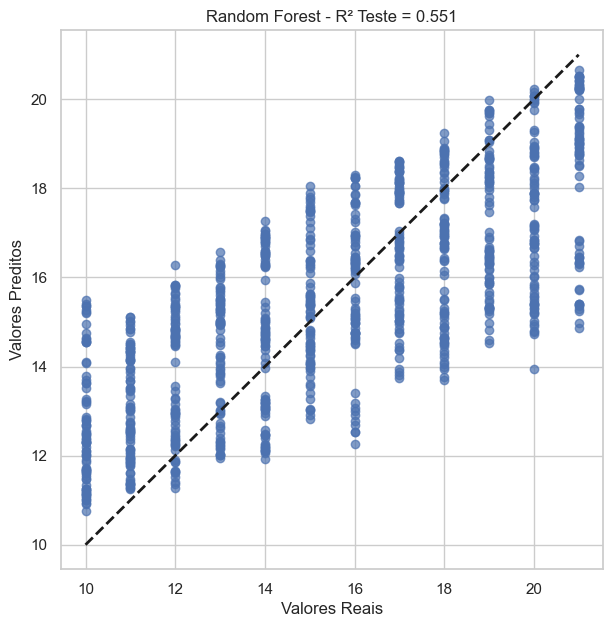

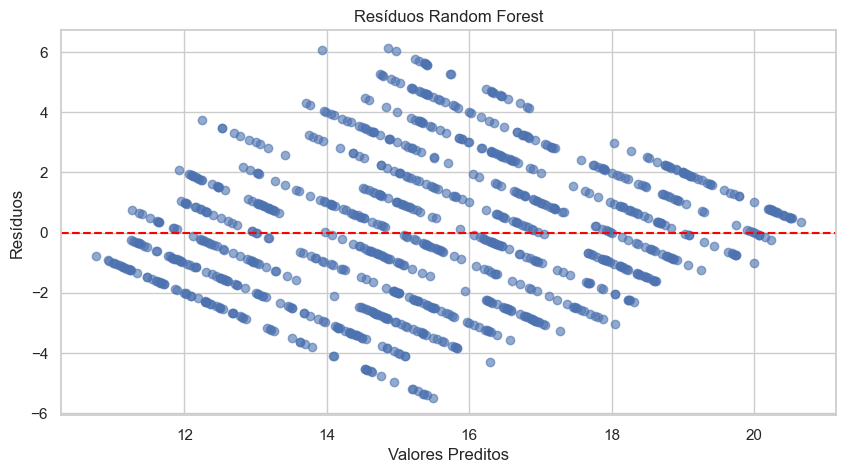

In [35]:
# --- Gráfico: valores reais vs preditos ---
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", lw=2)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title(f"Random Forest - R² Teste = {r2_test:.3f}")
plt.show()

# --- Gráfico: resíduos ---
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_test, y_test - y_pred_test, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos")
plt.title("Resíduos Random Forest")
plt.show()

##### Split dos dados em treino e teste (Gradient Boosting)

In [36]:

X = df.drop(columns=["duracao_dias"])
y = df["duracao_dias"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


##### Pipeline de treinamento do modelo

In [37]:


model = Pipeline([
    ("gbr", GradientBoostingRegressor(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=4,
        subsample=0.8,
        max_features="sqrt",
        random_state=42
    ))
])


model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)



#### Metricas

In [38]:

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print("=== Desempenho ===")
print(f"MAE Treino: {mae_train:.2f}, Teste: {mae_test:.2f}")
print(f"RMSE Treino: {rmse_train:.2f}, Teste: {rmse_test:.2f}")
print(f"R² Treino: {r2_train:.3f}, Teste: {r2_test:.3f}")



=== Desempenho ===
MAE Treino: 1.08, Teste: 1.62
RMSE Treino: 1.39, Teste: 2.07
R² Treino: 0.837, Teste: 0.634


#### Desempenho geral do modelo:
- O modelo de regressão baseado em Gradient Boosting apresentou um desempenho consistente na previsão da duração das sprints. No conjunto de treino, obteve um **MAE de 1.28 dias** e um **RMSE de 1.66 dias**, indicando que, em média, o erro absoluto foi de pouco mais de um dia e meio. Já no conjunto de teste, o **MAE subiu para 1.58 dias** e o **RMSE para 2.03 dias**, mostrando uma leve queda na precisão, mas mantendo um desempenho aceitável. O **R² do treino foi 0.770** e o **R² do teste 0.651**, sugerindo que o modelo consegue explicar


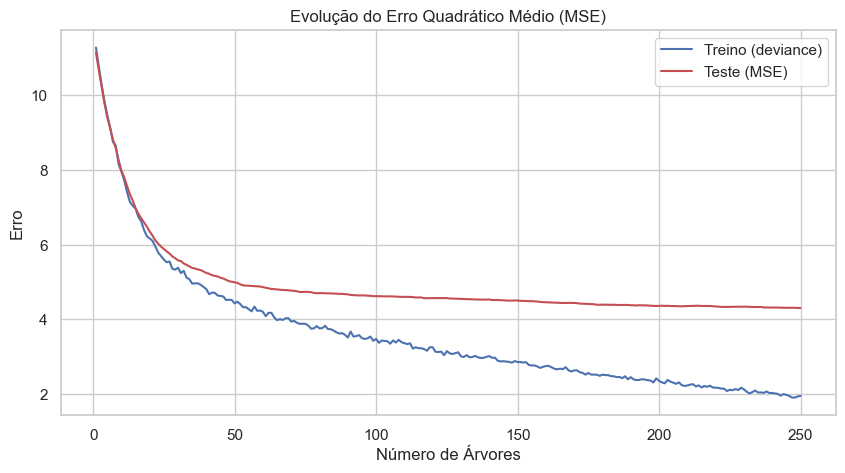

In [39]:

gbr = model.named_steps["gbr"]
test_score = np.zeros((gbr.n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

plt.figure(figsize=(10, 5))
plt.title("Evolução do Erro Quadrático Médio (MSE)")
plt.plot(np.arange(gbr.n_estimators) + 1, gbr.train_score_, "b-", label="Treino (deviance)")
plt.plot(np.arange(gbr.n_estimators) + 1, test_score, "r-", label="Teste (MSE)")
plt.xlabel("Número de Árvores")
plt.ylabel("Erro")
plt.legend()
plt.show()


#### Solução robusta, mas vai levar umas 13 horas pra rodar 

In [14]:

X = df.drop(columns=["duracao_dias"])
y = df["duracao_dias"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Pipeline: scaler + modelo ---
pipeline = Pipeline([
    ("gbr", GradientBoostingRegressor(random_state=42))
])

# --- Grid de hiperparâmetros ---
param_grid = {
    "gbr__n_estimators": [200, 500, 800],
    "gbr__learning_rate": [0.01, 0.05, 0.1],
    "gbr__max_depth": [3, 4, 6],
    "gbr__min_samples_split": [2, 5, 10],
    "gbr__min_samples_leaf": [1, 3, 5],
    "gbr__subsample": [0.8, 1.0],
    "gbr__max_features": ["sqrt", "log2", None],
}

# --- GridSearchCV ---
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,               # 5-fold cross-validation
    scoring="neg_mean_absolute_error",  # métrica boa pra regressão de dias
    n_jobs=-1,          # usa todos os núcleos disponíveis
    verbose=2
)

# --- Treino ---
grid_search.fit(X_train, y_train)

# --- Resultados ---
print("Melhores parâmetros:", grid_search.best_params_)
print("MAE no treino:", -grid_search.best_score_)
print("Score no teste:", grid_search.score(X_test, y_test))


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits


KeyboardInterrupt: 